In [1]:
from models import SequenceDNN_Regression

from collections import OrderedDict
from pprint import pprint
from warnings import warn

import numpy as np
import matplotlib.pyplot as plt

import math

%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5005)
/usr/local/anaconda3/envs/regression_dragonn_new/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
data_dir = 'data/'
model_dir = 'models/'

acceptable_keys = {}
    
key_to_seq = {}
seq_len = 145

with open("../../data/Scaleup_counts_sequences/ScaleUpDesign1.sequences.txt") as f:
    for line in f:
        key, seq = line.strip().split()
        cats = key.split('_')
        bucket = "".join([cats[0], cats[4], cats[5]])

        if "N" in seq:
            seq = seq.replace("N", "A")

        if bucket not in key_to_seq:
            key_to_seq[bucket] = [(seq, key)]
        else:
            key_to_seq[bucket].append((seq, key))

with open("../../data/Scaleup_counts_sequences/ScaleUpDesign2.sequences.txt") as f:
    for line in f:
        key, seq = line.strip().split()
        cats = key.split('_')
        bucket = "".join([cats[0], cats[4], cats[5]])

        if "N" in seq:
            seq = seq.replace("N", "A")

        if bucket not in key_to_seq:
            key_to_seq[bucket] = [(seq, key)]
        else:
            key_to_seq[bucket].append((seq, key))

test_prop = 0.2
valid_prop = 0.2
indices = np.random.permutation(len(key_to_seq))
train_key_to_seq = OrderedDict()
for i in xrange(int((1 - test_prop - valid_prop) * len(indices))):
    for pair in key_to_seq[key_to_seq.keys()[indices[i]]]:
        train_key_to_seq[pair[1]] = pair[0]
        acceptable_keys[pair[1]] = None
valid_key_to_seq = OrderedDict()
for i in xrange(int((1 - test_prop - valid_prop) * len(indices)), int((1 - test_prop) * len(indices))):
    for pair in key_to_seq[key_to_seq.keys()[indices[i]]]:
        valid_key_to_seq[pair[1]] = pair[0]
        acceptable_keys[pair[1]] = None
test_key_to_seq = OrderedDict()
for i in xrange(int((1 - test_prop) * len(indices)), len(indices)):
    for pair in key_to_seq[key_to_seq.keys()[indices[i]]]:
        test_key_to_seq[pair[1]] = pair[0]
        acceptable_keys[pair[1]] = None

In [108]:
print int((1 - test_prop - valid_prop) * len(indices)), int((1 - test_prop) * len(indices)), len(indices)

9432 12576 15720


In [109]:
print len(train_key_to_seq), len(valid_key_to_seq), len(test_key_to_seq), len(acceptable_keys)

292283 97426 97428 487137


In [4]:
data = {}
cell_types =  ["HepG2", "K562"]
promoters = ["SV40P", "minP"]
design_names = ["ScaleUpDesign1", "ScaleUpDesign2"]

for cell_type in cell_types:
    for promoter in promoters:
        experiment_key = (cell_type, promoter)
        data[experiment_key] = {}

        for design_name in design_names:

            with open("../../data/Scaleup_normalized/{}_{}_{}_mRNA_Rep1.normalized".format(cell_type, design_name, promoter)) as f:
                for line in f:
                    parts = line.strip().split()

                    key = parts[0]
                    val = float(parts[1])
                    if parts[2] == "1":
                        data[experiment_key][key] = val
                    else:
                        if key in acceptable_keys:
                            del acceptable_keys[key]

            with open("../../data/Scaleup_normalized/{}_{}_{}_mRNA_Rep2.normalized".format(cell_type, design_name, promoter)) as f:
                for line in f:
                    parts = line.strip().split()

                    key = parts[0]
                    val = float(parts[1])
                    if parts[2] == "1":
                        assert key in data[experiment_key]
                        data[experiment_key][key] = (val + data[experiment_key][key]) / 2.0
                    else:
                        if key in acceptable_keys:
                            del acceptable_keys[key]

# One hot encode DNA sequences the standard way.
bases = ['A', 'T', 'C', 'G']

def one_hot_encode_seq(seq):
    result = np.zeros((len(bases), len(seq)))

    for i, base in enumerate(seq):
        result[bases.index(base), i] = 1

    return result

def seqs_to_encoded_matrix(seqs):
    # Wrangle the data into a shape that Dragonn wants.
    result = np.concatenate(
        map(one_hot_encode_seq, seqs)
    ).reshape(
        len(seqs), 1, len(bases), len(seqs[0])
    )

    # Check we actually did the encoding right.
    for i in range(len(seqs)):
        for j in range(len(seqs[0])):
            assert sum(result[i, 0, :, j]) == 1

    return result

In [111]:
len(test_key_to_seq), len(train_key_to_seq), len(acceptable_keys)

(97428, 292283, 277409)

In [112]:
for key in train_key_to_seq.keys()[:10]:
    print key

Huvec_22_0_0_chr2_173924895
Huvec_22_0_1_chr2_173924895
Huvec_22_0_2_chr2_173924895
Huvec_22_0_3_chr2_173924895
Huvec_22_0_4_chr2_173924895
Huvec_22_0_5_chr2_173924895
Huvec_22_0_6_chr2_173924895
Huvec_22_0_7_chr2_173924895
Huvec_22_0_8_chr2_173924895
Huvec_22_0_9_chr2_173924895


In [5]:
from sklearn.utils import shuffle

X_train = seqs_to_encoded_matrix([train_key_to_seq[key] 
                                  for key in train_key_to_seq
                                  if key in acceptable_keys])
X_valid = seqs_to_encoded_matrix([valid_key_to_seq[key] 
                                  for key in valid_key_to_seq
                                  if key in acceptable_keys])
X_test =  seqs_to_encoded_matrix([test_key_to_seq[key] 
                                  for key in test_key_to_seq
                                  if key in acceptable_keys])

y_train = []
y_valid = []
y_test = []

from sklearn.preprocessing import StandardScaler

for experiment_key, key_to_normalized in data.items():

    filtered_normalized_all = np.array([key_to_normalized[key] for key in acceptable_keys]).reshape(-1, 1)
    
    scaler = StandardScaler()
    scaler.fit(filtered_normalized_all)
    
    y_train += [scaler.transform(np.array([key_to_normalized[key] 
                                           for key in train_key_to_seq 
                                           if key in acceptable_keys]).reshape(-1, 1))]
    y_valid += [scaler.transform(np.array([key_to_normalized[key] 
                                           for key in valid_key_to_seq 
                                           if key in acceptable_keys]).reshape(-1, 1))]
    y_test += [scaler.transform(np.array([key_to_normalized[key] 
                                          for key in test_key_to_seq 
                                          if key in acceptable_keys]).reshape(-1, 1))]

y_train = np.hstack(y_train)
y_valid = np.hstack(y_valid)
y_test  = np.hstack(y_test)

tasks = data.keys()

In [114]:
X_valid.shape

(55096, 1, 4, 145)

In [115]:
y_valid.shape

(55096, 4)

In [116]:
print X_valid[0, 0, :, :10]

[[ 0.  0.  0.  1.  1.  0.  0.  1.  1.  0.]
 [ 1.  1.  0.  0.  0.  1.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]


In [6]:
def kmerize(X, k):
    """
    Returns np.array of kmer counts corresponding to given seq
    """
    X = X.reshape(-1, 4, 145).swapaxes(1, 2).argmax(axis = 2)
    bases = ['00', '01', '10', '11']
    counts = []
    for seq in X:
        binary_seq = ''.join(map(lambda x: bases[x], seq))
        count = np.zeros((4**k,), dtype = int)
        for i in range(0, len(seq) - k + 1):
            count[int(binary_seq[i*2:(i+k)*2], 2)] += 1
        counts += [count]
    return np.vstack(counts)

Xk_train = kmerize(X_train, 6)
Xk_test = kmerize(X_test, 6)

In [7]:
from sklearn.linear_model import SGDRegressor
lasso_models = []
for task in range(y_train.shape[1]):
    lasso_models += [SGDRegressor(penalty = 'l1').fit(Xk_train, y_train[:, task])]#, sample_weight = w_train)]

0.964800633885 0.0410056087309
(0.25486354120443289, 0.0)


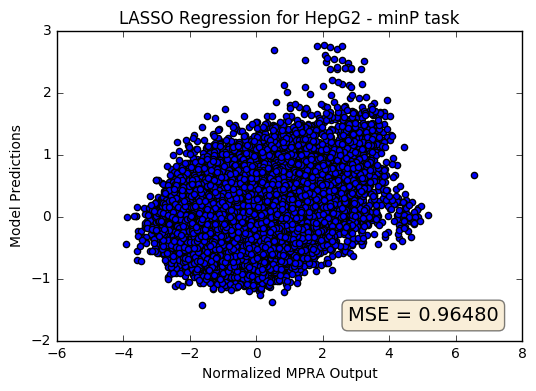

0.899569576823 0.0661352670127
(0.28725399229401605, 0.0)


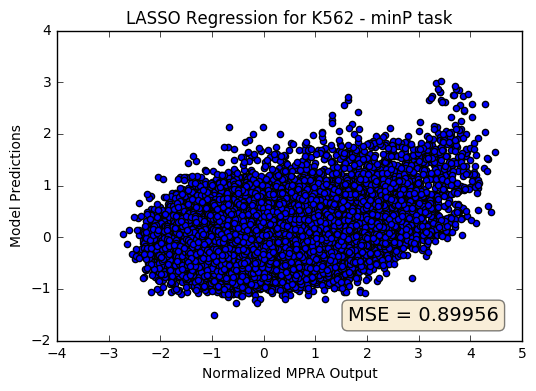

0.960270415723 0.0660253673123
(0.2914849955911607, 0.0)


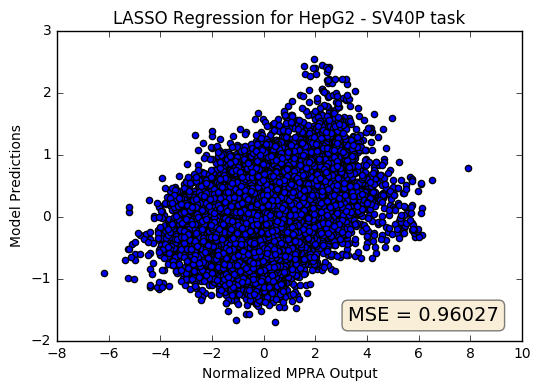

0.973676380189 0.0174951422222
(0.1732089628336439, 0.0)


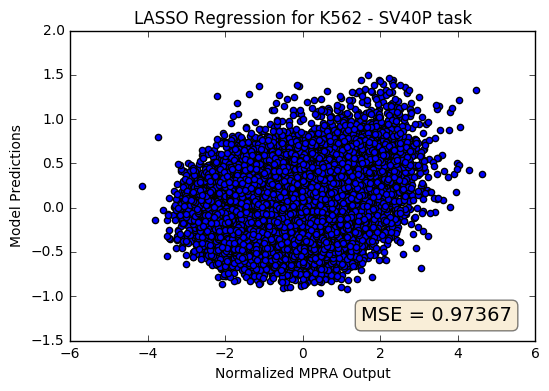

In [128]:
from metrics import r2_score, mean_squared_error
from scipy.stats import pearsonr


TASKS = ['HepG2 - minP', 'K562 - minP', 'HepG2 - SV40P', 'K562 - SV40P']
def plot_predictions(models, name):
    for task, model in enumerate(models):
        ax = plt.subplot(111)
        mse = mean_squared_error(y_test[:, task], model.predict(Xk_test))
        r2 = r2_score(y_test[:, task], model.predict(Xk_test))
        print mse, r2
        print pearsonr(y_test[:, task], model.predict(Xk_test))
        plt.scatter(y_test[:, task], model.predict(Xk_test), lw = 1)
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(0.95, 0.05, "MSE = {}".format(str(mse)[:7]), transform=ax.transAxes, fontsize=14,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)
        
        plt.ylabel("Model Predictions")
        plt.xlabel("Normalized MPRA Output")
        plt.title("{} for {} task".format(name, TASKS[task]))
        plt.show()
def plot_cnn_predictions(models, name):
    preds = model.predict(X_test)
    for i, task in enumerate(TASKS):
        ax = plt.subplot(111)
        mse = mean_squared_error(y_test[:, i], preds[:, i])
        r2 = r2_score(y_test[:, i], preds[:, i])
        print mse, r2
        print pearsonr(y_test[:, i], preds[:, i])
        plt.scatter(y_test[:, i], preds[:, i], lw = 1)
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        plt.text(0.95, 0.05, "MSE = {}".format(str(mse)[:7]), transform=ax.transAxes, fontsize=14,
            verticalalignment='bottom', horizontalalignment='right', bbox=props)
        
        plt.ylabel("Model Predictions")
        plt.xlabel("Normalized MPRA Output")
        plt.title("{} for {} task".format(name, task))
        plt.show()
plot_predictions(lasso_models, 'LASSO Regression')

In [130]:
import os.path

fn = "from_paper"
fn = model_dir + fn
model = SequenceDNN_Regression(
    seq_length=X_train.shape[3],
    num_filters=[100, 100],
    conv_width=[8, 15],
    pool_width=124,
    num_tasks=y_train.shape[1],
    dropout=0.1
)

In [121]:
model.train(X_train, y_train, (X_valid, y_valid))

Training model (* indicates new best result)...
Epoch 1:
Train Task 0: Mean Squared Error: 0.8893	Mean Absolute Error: 0.7308	 Median Absolute Error: 0.5859	 R2 Score: 0.1075
Task 1: Mean Squared Error: 0.8879	Mean Absolute Error: 0.7654	 Median Absolute Error: 0.6718	 R2 Score: 0.1170
Task 2: Mean Squared Error: 0.8847	Mean Absolute Error: 0.6819	 Median Absolute Error: 0.4928	 R2 Score: 0.1051
Task 3: Mean Squared Error: 0.9627	Mean Absolute Error: 0.7612	 Median Absolute Error: 0.6033	 R2 Score: 0.0363
Valid Task 0: Mean Squared Error: 0.9659	Mean Absolute Error: 0.7554	 Median Absolute Error: 0.6010	 R2 Score: 0.0384
Task 1: Mean Squared Error: 0.9841	Mean Absolute Error: 0.7966	 Median Absolute Error: 0.6923	 R2 Score: 0.0349
Task 2: Mean Squared Error: 0.9660	Mean Absolute Error: 0.7052	 Median Absolute Error: 0.5038	 R2 Score: 0.0395
Task 3: Mean Squared Error: 1.0095	Mean Absolute Error: 0.7748	 Median Absolute Error: 0.6068	 R2 Score: 0.0023 *
Epoch 2:
Train Task 0: Mean Squar

In [122]:
model.plot_architecture(fn + '.png')
SequenceDNN_Regression.save(model, fn)

0.934957577823 0.070669067042
(0.275376302894009, 0.0)


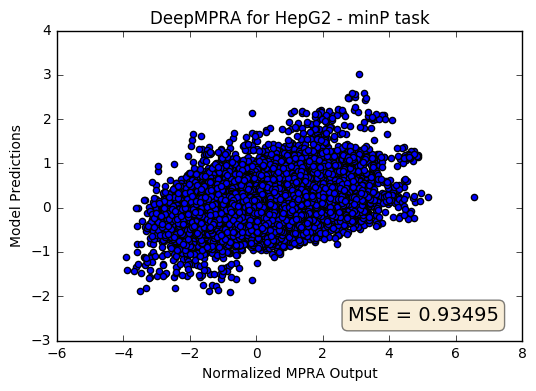

0.904307479644 0.0612167365654
(0.26358578522410503, 0.0)


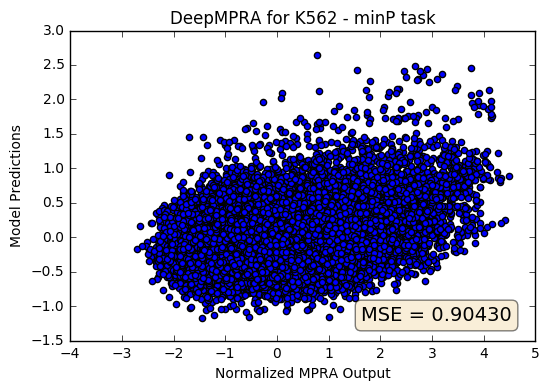

0.942469599839 0.0833387305112
(0.29541623184611154, 0.0)


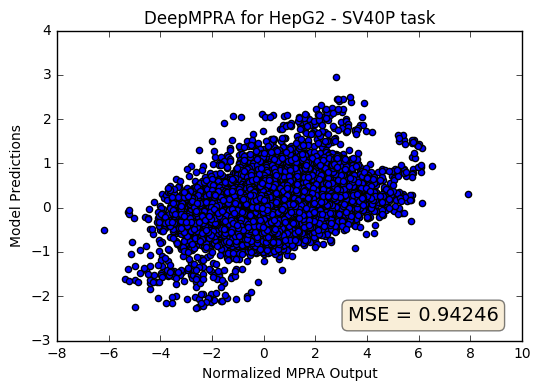

0.975958157978 0.0151926751936
(0.15726902955267111, 1.6171628563571673e-305)


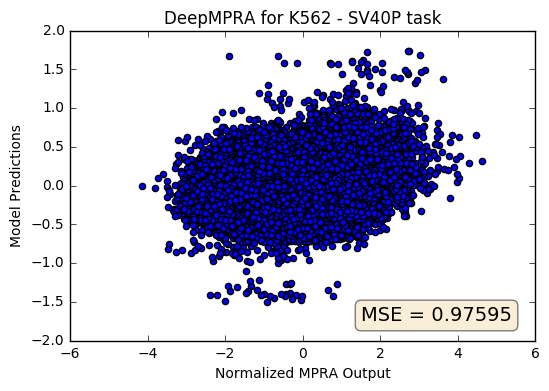

In [131]:
model.model.load_weights(fn+'.weights.h5')
plot_cnn_predictions(model, 'DeepMPRA')

In [124]:
fn = "from_paper2"
fn = model_dir + fn
model = SequenceDNN_Regression(
    seq_length=X_train.shape[3],
    num_filters=[100, 100],
    conv_width=[8, 15],
    pool_width=124,
    num_tasks=y_train.shape[1],
    dropout=0.2
)

In [125]:
model.train(X_train, y_train, (X_valid, y_valid))

Training model (* indicates new best result)...


KeyboardInterrupt: 

In [126]:
model.plot_architecture(fn + '.png')
model.save(fn)

0.983954449098 0.0219670626148


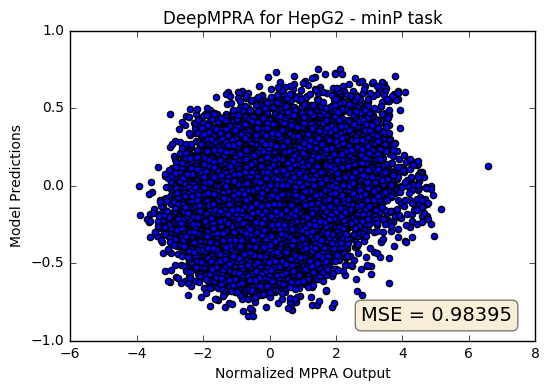

0.925707532998 0.0390008283951


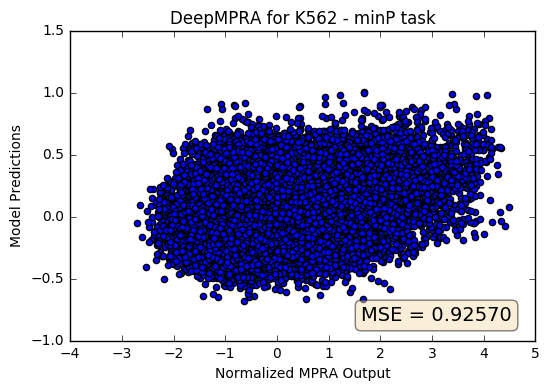

0.991264314456 0.0358801970446


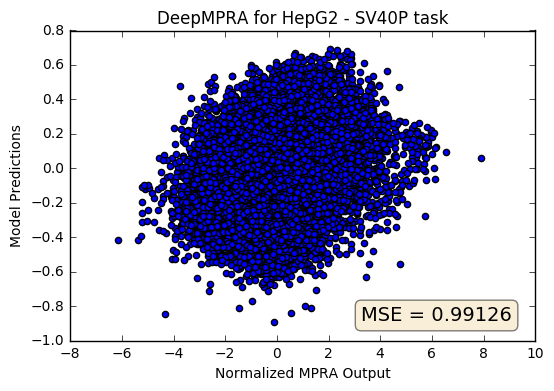

0.981286042705 0.00981648169429


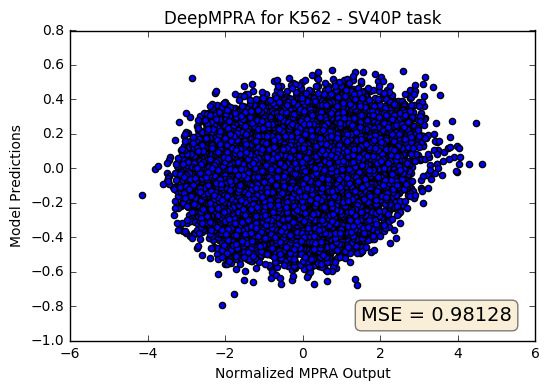

In [127]:
model.model.load_weights(fn+'.weights.h5')
plot_cnn_predictions(model, 'DeepMPRA')

In [13]:
import matplotlib.gridspec as gridspec

def print_perf(model, metric):
    train_losses, valid_losses = [np.array([epoch_metrics[metric] for epoch_metrics in metrics])
                                  for metrics in (model.train_metrics, model.valid_metrics)]

    # Pretty sure early stopping works by taking the mean of losses, might want to double check
    mean_train_losses = train_losses.mean(axis=1)
    mean_valid_losses = valid_losses.mean(axis=1)
    min_loss_indx = min(enumerate(mean_valid_losses), key=lambda x: x[1])[0]
    
    gs = gridspec.GridSpec(3, 2)
    f = plt.figure(figsize=(15,10))

    for i in range(train_losses.shape[1]):
        y_max = max(max(train_losses[:,i]), max(valid_losses[:,i])) * 1.1

        ax = f.add_subplot(gs[i])

        ax.plot(range(len(train_losses[:,i])), train_losses[:,i], label='Training',lw=2)
        ax.plot(range(len(train_losses[:,i])), valid_losses[:,i], label='Validation', lw=2)
        
        ax.plot([min_loss_indx, min_loss_indx], [0, y_max], 'k--', label='Early Stop')
        if i == 0:
            ax.legend(loc="best")
            ax.set_ylabel(metric)
        ax.set_ylim((0,y_max))
        ax.set_title("Task {}".format(i))

    y_max = max(max(mean_train_losses), max(mean_valid_losses)) * 1.1

    ax = f.add_subplot(gs[train_losses.shape[1]])
    ax.plot(range(len(mean_train_losses)), mean_train_losses, label='Training',lw=2)
    ax.plot(range(len(mean_valid_losses)), mean_valid_losses, label='Validation', lw=2)
        
    ax.plot([min_loss_indx, min_loss_indx], [0, y_max], 'k--', label='Early Stop')
    ax.set_ylim((0,y_max))
    ax.set_xlabel("Epoch")
    ax.set_title("Mean losses")
        
    plt.savefig(fn + ".losses.png")
    plt.show()